# Extract all fitted params from many dates in OGA butler in 2023

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-03-18
- last update : 2024-03-26
- affiliation : IJCLab/IN2P3/CNRS
- w_2024_10
- Spectractor v3.0.3

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.colors as mcolors
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys

In [3]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
machine_name = os.uname().nodename
print(machine_name)
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    #machine_name_notebook platform = 'dagoret-nb'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2024_07/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)   
elif "dagoret-nb" in machine_name:
    print("Set environement for Rubin Platform at  USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2024_07/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

dagoret-nb
Set environement for Rubin Platform at  USDF


In [6]:
dm_version="w_2024_10" 
machine_name = os.uname().nodename
print(machine_name)
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    #machine_name_notebook platform = 'dagoret-nb'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),f"repos/{dm_version}/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)   
elif "dagoret-nb" in machine_name:
    print("Set environement for Rubin Platform at  USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),f"repos/{dm_version}/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

dagoret-nb
Set environement for Rubin Platform at  USDF


In [7]:
sys.path.append("../lib")
from libanaspectra import *
from config_spectractor import *

In [8]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

#README.md        darksky.dat      filter_r.dat     hardware_g.dat   hardware_y.dat   lens3.dat        total_g.dat      total_y.dat
#README_SOURCE.md detector.dat     filter_u.dat     hardware_i.dat   hardware_z.dat   m1.dat           total_i.dat      total_z.dat
#atmos_10.dat     filter_g.dat     filter_y.dat     hardware_r.dat   lens1.dat        m2.dat           total_r.dat      version_info
#atmos_std.dat    filter_i.dat     filter_z.dat     hardware_u.dat   lens2.dat        m3.dat           total_u.dat
hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [9]:
#FILTERWL: precalculated array containing center, boundaries and width of each filter.
#index 0 : minimum wavelength of filter border
#index 1 : minimum wavelength of filter border
#index 2 : center wavelength of filter
#index 3 : filter width


FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

FILTERWL_auxtel = np.array([[ 352.7 ,  395.9 ,  374.3 ,   43.2 ],
                     [ 387.6 ,  566.2 ,  476.9 ,  178.6 ],
                     [ 541.4 ,  715.5 ,  628.45,  174.1 ],
                     [ 673.3 ,  870.9 ,  772.1 ,  197.6 ],
                     [ 805.6 , 1090.7 ,  948.15,  285.1 ]])


F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
Jy_to_ergcmm2sm1hzm1 = 1e-23
DT = 30.0 # seconds
gel = 1.1
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
A  = np.pi*642.3**2 # cm2  Reff=6.423 m
A_auxtel  = 9636.0 # cm2

#ZPT_cont =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)
ZPTconst = 2.5*np.log10(F0*Jy_to_ergcmm2sm1hzm1*A*DT/gel/hP)

In [10]:
fdir = get_data_dir()
bandpass_inst = {}
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=WL,sb=ff(WL))

In [11]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(WL,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(WL,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total Rubin-LSST filter throughput")

Text(0.5, 1.0, 'Total Rubin-LSST filter throughput')

In [12]:
#from lsst.summit.utils.utils import checkStackSetup
#checkStackSetup()

In [13]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208/20231220T142452Z
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221/20231221T125249Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240201/20240201T144534Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N149.5/20240215T190316Z
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150
u/dagoret/auxtel_atmo_202401_v3.0.3_doGainsNOPTC_rebin2_240215_N150/2024

## Config

### Config collection

In [14]:
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

# all spectra from September 2022 to december 2023
#the reconstruction done by  LambdaMin = 350.0 and spectractor v3.0.3 in 2023/12/21

#my_collection = "u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"
my_collection = "u/jneveu/auxtel_atmosphere_202301_v3.1.0_doSensorFlat_rebin2_testWithMaskedEdges_newBoundaries_newPolysRescaled_newFitBounds_adjustA1_lockedOrder2_removeThroughputTails/20240313T174059Z" 

### Config Auxtel

In [15]:
spectractor.__path__[0]

'/home/d/dagoret/repos/repos_w_2024_07/Spectractor/lib/python/spectractor'

In [16]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_path = "/home/d/dagoret/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [17]:
print(config_fullpath)

/home/d/dagoret/repos/repos_w_2024_07/Spectractor/lib/python/spectractor/../config/auxtel.ini


In [18]:
# in w_2023_44 I had to load explicitely
# in w_2024_07 Apparently the parameters is well loaded and explicit call to load_config fails
load_config_local(config_fullpath)

parameters.SPECTRACTOR_ATMOSPHERE_SIM =  getobstamo


### Config Telescope Throughtput

In [19]:
throughput_fullpath = os.path.join(spectractor.__path__[0],parameters.THROUGHPUT_DIR)
throughput_fullfilename = os.path.join(throughput_fullpath,throughput_filename)

In [20]:
tel_lambdas, tel_thr, tel_errthr = load_transmission(throughput_fullfilename) 

In [21]:
parameters.THROUGHPUT_DIR = throughput_fullpath 
parameters.OBS_FULL_INSTRUMENT_TRANSMISSON = throughput_filename
print(parameters.THROUGHPUT_DIR )
print(parameters.OBS_FULL_INSTRUMENT_TRANSMISSON)

/home/d/dagoret/repos/repos_w_2024_07/Spectractor/lib/python/spectractor/simulation/AuxTelThroughput/
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [22]:
%matplotlib inline
tel = TelescopeTransmission()
tel.plot_transmission()

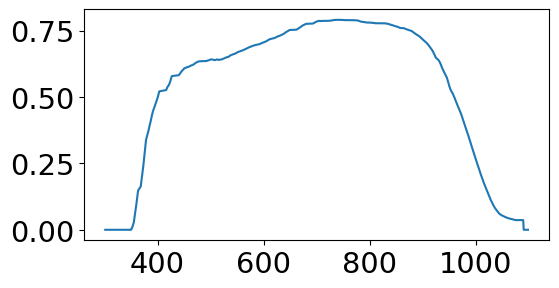

In [23]:
%matplotlib inline
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,tel.transmission(tel_lambdas))

### Config disperser

In [24]:
disp = dispersers.Hologram("holo4_003")

## Load config filename for Auxtel

In [25]:
#load_config(config_fullpath)

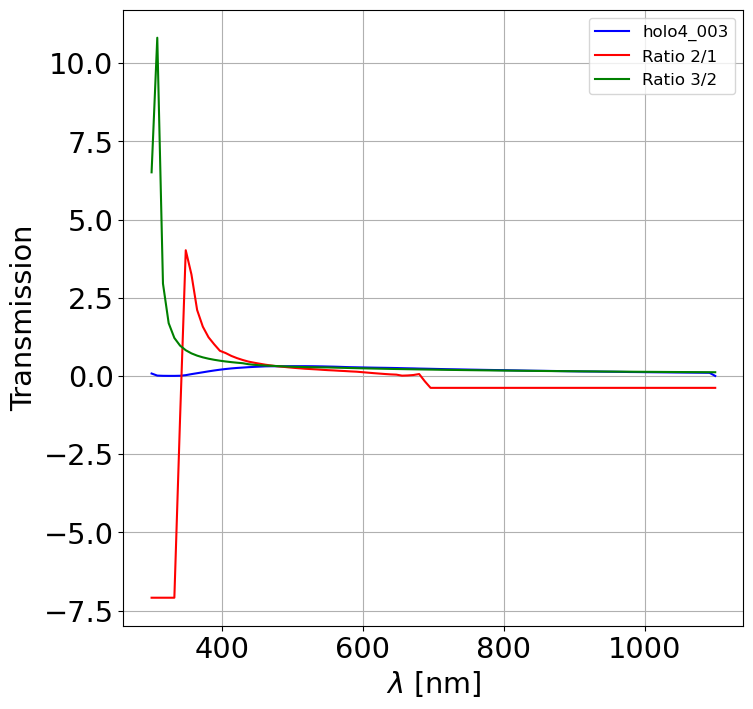

In [26]:
disp.plot_transmission()

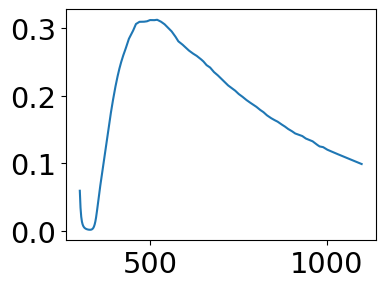

In [27]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,disp.transmission(tel_lambdas))

## Check the presence of the spectra

### select the date of observation in 2022 and 2023

In [28]:
ALL_DATEOBS = np.array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
       20230314, 20230315, 20230316, 20230509, 20230510, 20230511,
       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
       20230802, 20230815, 20230817, 20230829, 20230912, 20230913,
       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
       20231108, 20231113, 20231114, 20231115, 20231116, 20231120,
       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
       20231219, 20231220])

file_out_allfittedparams = "out_allfittedparams.csv"

- Split in 4 parts because too many files open

In [29]:

#ALL_DATEOBS = np.array([20220913, 20220914, 20220927, 20220928, 20220929, 20221011,
#       20221012, 20221025, 20221026, 20221027, 20221109, 20221110,
#       20221123, 20221207, 20221208, 20221209, 20221210, 20221212])
#file_out_allfittedparams = "out_allfittedparams_2022_3_3.csv"


#ALL_DATEOBS = np.array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
#       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
#       20230314, 20230315, 20230316]) 
#file_out_allfittedparams = "out_allfittedparams_2023_1_4.csv"
                        
#ALL_DATEOBS = np.array([20230509, 20230510, 20230511,
#       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
#       20230802, 20230815, 20230817, 20230829]) 
#file_out_allfittedparams = "out_allfittedparams_2023_2_4.csv"                        
                        
#ALL_DATEOBS = np.array([20230912, 20230913,
#       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
#       20231108, 20231113, 20231114, 20231115, 20231116]) 
#file_out_allfittedparams = "out_allfittedparams_2023_3_4.csv"


#ALL_DATEOBS = np.array([20231120,
#       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
#       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
#       20231219, 20231220])
#file_out_allfittedparams = "out_allfittedparams_2023_4_4.csv"

In [30]:
#DATEOBS = 20231207 # studied 2023/12/12
#DATEOBS = 20231206 # studied 2023/12/18
#DATEOBS = 20231205 # studied 2023/12/18
#DATEOBS = 20231204 # studied 2023/12/18
#DATEOBS = 20231130 # studied 2023/12/18
#DATEOBS = 20231129 # studied 2023/12/18
#DATEOBS = 20231128 # studied 2023/12/18
#DATEOBS = 20231127 # studied 2023/12/18

#DATEOBS = 20231120 # studied 2024/01/11 , not too bad
#DATEOBS = 20231116 # studied 2024/01/11 , not too bad
#DATEOBS = 20231115 # studied 2024/01/11 , not too bad, too short
#DATEOBS = 20231114 # studied 2024/01/11 , not too bad, too short
#DATEOBS = 20231113 # studied 2024/01/11 , not too bad, too short


# year 2022      
#ALL_DATEOBS = np.array([20220913, 20220914, 20220927, 20220928, 20220929, 20221011,
#       20221012, 20221025, 20221026, 20221027, 20221109, 20221110,
#       20221123, 20221207, 20221208, 20221209, 20221210, 20221212])
#file_out_allfittedparams = "out_allfittedparams_selected_13sept-12dec2022.csv"
                       
# beginning of year 2023                       
#ALL_DATEOBS = np.array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
#                        20230214, 20230215, 20230216, 20230228])                       
#file_out_allfittedparams = "out_allfittedparams_selected_1jan-28feb2023.csv"
#file_out_zp = "zp_selected_1jan-28feb2023.csv"

# Middle of the year 2023
#ALL_DATEOBS = np.array([
#       20230301, 20230302,
#       20230314, 20230315, 20230316,20230509, 20230510, 20230511,
#       20230523, 20230524, 
#       20230525, 
#       20230718, 20230720, 
       #20230801, # only one bad file
#       20230802, 20230815, 20230817, 20230829, 20230912, 20230913,
#       20230914])
#file_out_allfittedparams = "out_allfittedparams_selected_1march-14sept2023.csv"
#file_out_zp = "zp_selected_1march-14sept2023.csv"


# End of year 2023
ALL_DATEOBS = np.array([#20230926, 
                        20230927, 20230928, 
                        20231010, 
                        20231107,20231108,
                        20231113,20231114,20231115,20231116,20231120,20231127,20231128,20231129,
                        20231130,20231204,20231205,20231206,20231207]) 

file_out_allfittedparams = "out_allfittedparams_selected_27sept-07dec2023.csv"
file_out_zp = "zp_selected_27sept-07dec2023.csv"

In [31]:
len(ALL_DATEOBS)

18

## Access to spectra using the butler

In [32]:
all_records = []
count = 0
for DATEOBS in ALL_DATEOBS:
    where = f"instrument='LATISS' and visit.day_obs={DATEOBS}" 
    records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
    all_records.append(records)
    count += len(records)
    print(f">>> {DATEOBS} :  Number of records : ",len(records)," / ", count)
    

>>> 20230927 :  Number of records :  46  /  46
>>> 20230928 :  Number of records :  44  /  90
>>> 20231010 :  Number of records :  56  /  146
>>> 20231107 :  Number of records :  30  /  176
>>> 20231108 :  Number of records :  8  /  184
>>> 20231113 :  Number of records :  13  /  197
>>> 20231114 :  Number of records :  21  /  218
>>> 20231115 :  Number of records :  28  /  246
>>> 20231116 :  Number of records :  24  /  270
>>> 20231120 :  Number of records :  34  /  304
>>> 20231127 :  Number of records :  29  /  333
>>> 20231128 :  Number of records :  36  /  369
>>> 20231129 :  Number of records :  24  /  393
>>> 20231130 :  Number of records :  24  /  417
>>> 20231204 :  Number of records :  24  /  441
>>> 20231205 :  Number of records :  19  /  460
>>> 20231206 :  Number of records :  14  /  474
>>> 20231207 :  Number of records :  18  /  492


In [33]:
len(all_records)

18

## Get params, times, headers and Spectra

In [ ]:
all_params_spectrum = []
all_params_spectrogram = []
all_times = []
all_headers = []
all_spectra = []

for idx,DATEOBS in enumerate(ALL_DATEOBS):

    records = all_records[idx]
    print(idx,DATEOBS,len(records))
    params_spectrum = []
    params_spectrogram = []
    times = []
    headers = []
    spectra = []

    for i, r in enumerate(records):
        try:
            times.append(r.day_obs)
            spec =  butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            headers.append(spec.header)
            spectra.append(spec)
            p = butler.get('spectrumLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            params_spectrum.append(p)
            p = butler.get('spectrogramLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
            params_spectrogram.append(p)
    #except ValueError:
        except Exception as inst:
            except_type = type(inst)
            except_args = inst.args
            print("catch exception ", inst, "type =",except_type, "args = ",except_args) 
            print("\t >>>>> Skip record ", r.id)
            continue

    all_params_spectrum.append(params_spectrum)
    all_params_spectrogram.append(params_spectrogram)
    all_times.append(times)
    all_headers.append(headers)
    all_spectra.append(spectra)

0 20230927 46


## Filtering data

In [ ]:
all_filtered_spectra = []

count = 0
for idx,DATEOBS in enumerate(ALL_DATEOBS):
    records = all_records[idx]
    spectra_filtered = filter_data(butler,my_collection,DATEOBS,records)
    count += len(spectra_filtered)
    all_filtered_spectra.append(spectra_filtered)
    print(idx,DATEOBS,len(records),len(spectra_filtered),count)
    

## Information from atmospheric fits

In [ ]:
headers = all_headers[0]

In [ ]:
columns_spectrum = ["id"]

for h in headers[0]:
    if "COMMENT" in h or "EXTNAME" in h: continue
    if "LBDAS_T" in h or "PSF_P_T" in h or "AMPLIS_T" in h: continue
    if "UNIT" in h: continue
    if "SIMPLE" in h: continue
    columns_spectrum.append(h)
 
columns_spectrogram_bestfit = []
for key in params_spectrogram[0].labels:
    columns_spectrogram_bestfit.append(key)
    columns_spectrogram_bestfit.append(key+"_err")

columns_spectrum_bestfit = []
for key in params_spectrum[0].labels:
    columns_spectrum_bestfit.append(key)
    columns_spectrum_bestfit.append(key+"_err")

In [ ]:
print(columns_spectrum)

In [ ]:
print(columns_spectrogram_bestfit)

In [ ]:
print(columns_spectrum_bestfit)

## Merge dataframes of general parameters and fitted params

In [ ]:
all_df = []

for idx,DATEOBS in enumerate(ALL_DATEOBS):
  
    records = all_records[idx]
    headers = all_headers[idx]
    params_spectrogram = all_params_spectrogram[idx]
    params_spectrum = all_params_spectrum[idx]
   
    min_index = 0
    max_index = np.inf

    # General parameters
    df1 = pd.DataFrame(columns=columns_spectrum)
    for k, header in enumerate(headers):
        # if k > 40: break
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for h in header:
            if h in columns_spectrum:
                row[h] = header[h]
        df1.loc[len(df1)] = row


    # fitted parameters in Spectrogram
    df2 = pd.DataFrame(columns=columns_spectrogram_bestfit)
    for k, p in enumerate(params_spectrogram):
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for i, key in enumerate(p.labels):
            row[key] = p.values[i]
            row[key+"_err"] = p.err[i]
        df2.loc[len(df2)] = row

    # fitted parameters in Spectrum
    df3 = pd.DataFrame(columns=columns_spectrum_bestfit)
    for k, p in enumerate(params_spectrum):
        n = records[k].id
        if n < min_index or n > max_index: continue
        row = {"id": n}
        for i, key in enumerate(p.labels):
            row[key] = p.values[i]
            row[key+"_err"] = p.err[i]
        df3.loc[len(df3)] = row

    df = pd.merge(df1, df2, left_index=True, right_index=True)
    df = pd.merge(df, df3, left_index=True, right_index=True)
    df.set_index('DATE-OBS', inplace=True)
    #df.index = pd.to_datetime(df.index, format="ISO8601") #['DATE-OBS'])
    df.index = pd.to_datetime(df.index) #['DATE-OBS'])
    df.sort_index(inplace=True)

    all_df.append(df)
            

In [ ]:
all_df[0].head()

In [ ]:
all_df[1].head()

In [ ]:
df =  pd.concat(all_df)

In [ ]:
df_collist = list(df.columns)
for idx,col in enumerate(df_collist):
    print(idx,col)

## Write csv file

In [ ]:
# convert pandas to numpy rec array
rec = df.to_records()

In [ ]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
#filtered = filtered & (rec["reso [pix]"] < 3)
filtered = filtered & (rec["reso [nm]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

## Save filtering

In [ ]:
df["filtered"] =filtered

## Save atmospheric parameters and filters

In [ ]:
df.to_csv(file_out_allfittedparams) 

## Plot fitted parameters

In [ ]:
stars = np.unique(rec["TARGET"])
stars

In [ ]:
filters = np.unique(rec["FILTER"])
filters

In [ ]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.1,1.9]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,12.]
ATMMINMAX["VAOD_y"] = [0.,0.5]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.1,1.9]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,12.]
ATMMINMAX["VAOD_x"] = [0.,0.2]
ATMMINMAX["A2_x"] = [0.7,1.3]
ATMMINMAX["angstrom_exp_x"] = [0.,4.]

## Plot fitted parameters

In [ ]:
#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x", "gamma_0_1", "gamma_0_2", "alpha_0_1", "alpha_0_2", "y_c_0_1", "y_c_0_2" ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","angstrom_exp_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    #fig = plt.figure(figsize=(8,5))
    fig = plt.figure(figsize=(12,5))

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))



    for star in stars:
        index = filtered & (rec["TARGET"] == star) & (rec["FILTER"]=="empty")
        if col_err in df.columns:
            plt.errorbar(rec["AIRMASS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=10,lw=3 ,label=star)
        else:
            plt.plot(rec["AIRMASS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3 )
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    #plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()


In [ ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","angstrom_exp_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(12,5))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

In [ ]:
len(filtered)

In [ ]:
print(filtered)

In [ ]:
df.head()

In [ ]:
count = 0
all_lists_of_targets = []
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]
    N = len(filtered_spectra)
    count += N
    print(idx,DATEOBS,len(filtered_spectra),count) 
    list_of_targets = np.unique([spec.target.label for spec in filtered_spectra])
    print(">>> List of targets ",list_of_targets)
    all_lists_of_targets.append(list_of_targets)
   
    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]
    cut = (df.id == selected_ids[0])
    N = len(selected_ids)
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    
    if N>1:
        fig = plot_spectra(filtered_spectra, [spec.airmass for spec in filtered_spectra],collection=my_collection,dateobs=DATEOBS)
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")

## Make SED dictionnary

In [ ]:
list_of_all_targets = np.unique(np.concatenate(all_lists_of_targets))

In [ ]:
import getCalspec.getCalspec as gcal
all_calspecs = {}
for target_name in list_of_all_targets:
    c =  gcal.Calspec(target_name) 
    all_calspecs[target_name] = c.get_spectrum_numpy() 

In [ ]:
all_calspecs_sm = {}
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot()
span = 3
for target_name in list_of_all_targets:
    c_dict = all_calspecs[target_name]
    wls = c_dict["WAVELENGTH"].value
    sed = c_dict["FLUX"].value
    ax.plot(wls,sed,label=target_name)
    
    sedm = smooth_data_np_convolve(sed,span)
    c_dict_sm = {"WAVELENGTH":wls,"FLUX":sedm}
    all_calspecs_sm[target_name] = c_dict_sm
    ax.plot(wls,sedm,label="smooth " +target_name)
ax.legend()
ax.set_xlim(3000.,10000.)   
ax.set_ylim(0.,0.5e-10)

In [ ]:
all_calspecs_sm

## Plot atmospheric transmissions

In [ ]:
count = 0
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]

    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]
    cut = (df.id == selected_ids[0])
    N = len(selected_ids)
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    
    if N > 1:
        plot_atmtransmission(filtered_spectra, [spec.airmass for spec in filtered_spectra],all_calspecs_sm,tel,disp,collection=my_collection,dateobs=DATEOBS)
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")


## Plot atmospheric transmissions for airmass = 1

$$
T(z_{pred}) = \frac{ \left( T(z_{meas}) \right)^\left( \frac{z_{pred}}{z_{meas}}\right)}{(T^{grey}_{z_{meas}})^{z_{pred}}}
$$

In [ ]:
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]

    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]
    cut = (df.id == selected_ids[0])
    N = len(selected_ids)
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    

    if N > 1:
        plot_atmtransmission_zcorr(filtered_spectra, [ spec.airmass for spec in filtered_spectra ],all_calspecs_sm,tel,disp,collection=my_collection,dateobs=DATEOBS )
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")    

## Show with simulation

In [ ]:
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]
    
    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]
    cut = (df.id == selected_ids[0])
    N = len(selected_ids)
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])

    break
    

In [ ]:
df_good = df_sel[df_sel.filtered].drop(["id","filtered"],axis=1)
m_A1 , m_ozone, m_PWV, m_VAOD = df_good.mean().values
print(m_A1 , m_ozone, m_PWV, m_VAOD)

In [ ]:
for spec in filtered_spectra:
    row = df_sel[df_sel.id == spec.dataId]
    (s_id, s_target, s_A1, s_ozone, s_PWV, s_VAOD, s_flag) = row.values[0]
    if s_flag:
        pwv=s_PWV
        oz=s_ozone
        vaod=s_VAOD
        grey=s_A1
    else:
        pwv=m_PWV
        oz=m_ozone
        vaod=m_VAOD
        grey=m_A1

In [ ]:
allall_meas_atmtransmissions_z1 = []
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]
    
    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]
    cut = (df.id == selected_ids[0])
    N = len(selected_ids)
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    
    if N> 1:
    #plot_atmtransmission_zcorr(filtered_spectra, [ spec.airmass for spec in spectra_filtered ],all_calspecs_sm,tel,disp,collection=my_collection,dateobs=DATEOBS )
        try:
            all_meas_atmtransmissions_z1 = plot_atmtransmission_zcorr_antatmsim(filtered_spectra, [ spec.airmass for spec in filtered_spectra ],all_calspecs_sm,tel,disp,collection=my_collection,dateobs=DATEOBS,df_atm = df_sel)
            allall_meas_atmtransmissions_z1.append(all_meas_atmtransmissions_z1)
        except Exception as inst:
            print(type(inst))    # the exception type
            print(inst.args)     # arguments stored in .args
            print(inst)          # __str__ allows args to be printed directly,
                                 # but may be overridden in exception subclasses
            id0 = filtered_spectra[0].dataId
            id1 = filtered_spectra[-1].dataId
            print(f" \n >>>>>>>> EXCEPTION SKIPP {id0} - {id1} \n")
            allall_meas_atmtransmissions_z1.append([])
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")
        allall_meas_atmtransmissions_z1.append([])
    

In [ ]:
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]

    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]
    cut = (df.id == selected_ids[0])
    N = len(selected_ids)
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    

    if N> 1:   
        plot_atmtransmission_zcorr_antatmsim_ratio(filtered_spectra, [spec.airmass for spec in filtered_spectra],
                                                    all_calspecs_sm,tel,disp,collection = my_collection,dateobs=DATEOBS, df_atm = df_sel )
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")            

## Save in HDF5

In [ ]:
for idx,filtered_spectra in enumerate(all_filtered_spectra):
    DATEOBS = ALL_DATEOBS[idx]

    # selection of fitted parameters
    selected_ids = [spec.dataId for spec in filtered_spectra]
    cut = (df.id == selected_ids[0])
    N = len(selected_ids)
    for idx in range(1,N):
        cut = cut | (df.id == selected_ids[idx])
    df_sel = df[cut][["id","TARGET","A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x","filtered"]]
    
    print(">>> ID.     : ",DATEOBS, selected_ids)
    print(">>> AIRMASS : ",DATEOBS, [spec.airmass for spec in filtered_spectra])
    #print(df_sel)
    

    if N> 1:   
        savehdf5_atmtransmission_zcorr_antatmsim_ratio(filtered_spectra, [spec.airmass for spec in filtered_spectra],
                                                    all_calspecs_sm,tel,disp,collection = my_collection,dateobs=DATEOBS, df_atm = df_sel)
        #plot_atmtransmission_zcorr_antatmsim_ratio(filtered_spectra, [spec.airmass for spec in filtered_spectra],
        #                                            all_calspecs_sm,tel,disp,collection = my_collection,dateobs=DATEOBS, df_atm = df_sel )
    else:
        id = filtered_spectra[0].dataId
        print(f" \n /////// SKIPP {id} \n")    

# Total transmission and zero points

In [ ]:
def compute_total_transm(filter,meas_atmtransm):
    """
    """
    N = len(meas_atmtransm)
    bd = bandpass_inst[filter]
    func = interpolate.interp1d(x=bd.wavelen, y=bd.sb ,fill_value="extrapolate")
    all_total_transm = []
    for idx in range(N):
        the_wl = meas_atmtransm[idx][0]
        the_atm = meas_atmtransm[idx][1]
        the_totaltrans = the_atm * func(the_wl)
        all_total_transm.append((the_wl,the_totaltrans))
    return all_total_transm

In [ ]:
all_all_total_transm = []
all_selectednights = []

# loop on all transmission of a given night
for idx,  all_meas_atmtransmissions_z1 in enumerate(allall_meas_atmtransmissions_z1): 
    DATEOBS = ALL_DATEOBS[idx]

    if len(all_meas_atmtransmissions_z1)>1:
        all_selectednights.append(True) 
        all_total_transm = {} 
        # loop on filters
        for index,f in enumerate(filter_tagnames):
            all_total_transm[f] = compute_total_transm(f,all_meas_atmtransmissions_z1)
        
        all_all_total_transm.append(all_total_transm )
    else:
        all_all_total_transm.append({})
        all_selectednights.append(False) 
        

In [ ]:
for idx0,all_total_transm in enumerate(all_all_total_transm):
    
    DATEOBS = ALL_DATEOBS[idx0]
    if all_selectednights[idx0]:
    

        fig, axs = plt.subplots(1,1,figsize=(10,4))
        for index,f in enumerate(filter_tagnames):
    
            N = len(all_total_transm[f])
            for idx in range(N):
                the_wl = all_total_transm[f][idx][0] 
                the_tottransm = all_total_transm[f][idx][1] 
                if index==0 or index==5:
                    axs.plot(the_wl,the_tottransm ,color=filter_color[index],alpha=0.1) 
                else:
                    axs.plot(the_wl,the_tottransm ,color=filter_color[index]) 
            axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
        axs.set_xlabel("$\\lambda$ (nm)")
        axs.set_title("Measured total Rubin-LSST filter throughput",fontsize=14)
        axs.set_ylim(0,0.6)
        suptitle = f"obs : {DATEOBS} , nspec = {N}\n coll = {my_collection}"
        plt.suptitle(suptitle,fontsize=10,y=1.0)
        plt.tight_layout()
        plt.show()    

### Compute integrals

In [ ]:
all_all_total_II0 = []
#all_all_total_II0_mjd = []


# loop on dates
for idx0,all_total_transm in enumerate(all_all_total_transm):
    
    DATEOBS = ALL_DATEOBS[idx0]
    if all_selectednights[idx0]:
        
        all_total_II0 = {} 
   
        for index,f in enumerate(filter_tagnames):
    
            N = len(all_total_transm[f])
            all_II0 = np.zeros(N)
                
            for idx in range(N):
                the_wl = all_total_transm[f][idx][0] 
                the_tottransm = all_total_transm[f][idx][1] 
                #print( DATEOBS,f,idx,N,len(the_wl),the_tottransm.min(),the_tottransm.max())
                
                try:    
                    all_II0[idx] = fII0(the_wl,the_tottransm)
                except Exception as inst:
                    print(f">>>> Exception in {DATEOBS}, filter {f} , idx = {idx}/{N}")
                    print(type(inst))    # the exception type
                    print(inst.args)     # arguments stored in .args
                    print(inst)          # __str__ allows args to be printed directly,
                    # if calculation fails, put a NaN
                    all_II0[idx] = np.nan

            # remove NaN
            all_total_II0[f] = all_II0[~np.isnan(all_II0)]
            
        all_all_total_II0.append(all_total_II0)
         
    else:
        all_all_total_II0.append({})
       
        
        

In [ ]:
np.nan

In [ ]:
all_zp = []

for idx0, all_total_II0 in enumerate(all_all_total_II0):
    
    DATEOBS = ALL_DATEOBS[idx0]
    if all_selectednights[idx0]:
        zp = {}
        for index,f in enumerate(filter_tagnames):
            zp[f] = 2.5*np.log10(all_total_II0[f]) 
        
        all_zp.append(zp)
    else:
        all_zp.append({})

In [ ]:
for idx0, zp in enumerate(all_zp):
    DATEOBS = ALL_DATEOBS[idx0]
    if all_selectednights[idx0]:

        fig, axs = plt.subplots(1,4,figsize=(18,4))
        for index,f in enumerate(filter_tagnames):
            if index==0 or index==5:
                continue
            X = (zp[f] - np.median(zp[f]))*1000.
            N = len(X)
            X = X[np.where(np.abs(X)<50)]
            std = np.std(X)
            label = f"$\sigma$({f})={std:.1f} mmag"
            axs[index-1].hist(X,bins=30,range=(-50,50),color=filter_color[index],alpha=0.5,label=label)
            axs[index-1].grid()
            #axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            axs[index-1].legend(loc='upper left')
            axs[index-1].set_xlabel("ZP resolution (mmag)",fontsize=12)
        suptitle = f"obs : {DATEOBS} , nspec = {N}\n coll = {my_collection}"
        plt.suptitle(suptitle,fontsize=10,y=1.0)
        plt.tight_layout()
        plt.show()

### Summary for zero point repeatability 

In [ ]:
df_zp = pd.DataFrame(columns= ["dateobs","dZp_u","dZp_g","dZp_r","dZp_i","dZp_z","dZp_y"]) 
icount = 0
for idx0, zp in enumerate(all_zp):
    DATEOBS = ALL_DATEOBS[idx0]
    data = []
    
    if all_selectednights[idx0]:
        data.append(int(DATEOBS))
        for index,f in enumerate(filter_tagnames): 
            X = (zp[f] - np.median(zp[f]))*1000.
            N = len(X)
            X = X[np.where(np.abs(X)<50)]
            std = np.std(X)
            data.append(std)

        df_zp.loc[icount] = data
        icount +=1
            
           

In [ ]:
df_zp

In [ ]:
df_zp.to_csv(file_out_zp)

In [ ]:
def convertNumToDatestr(num):
    num = int(num)
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [ ]:
df_zp["dateobsstr"] = df_zp["dateobs"].apply(convertNumToDatestr)

In [ ]:
df_zp["datetime"] = pd.to_datetime(df_zp["dateobsstr"])

In [ ]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=4)
hour_locator = mdates.HourLocator(interval=6)

fmt = '%D %H:%M:'
#year_month_formatter = mdates.DateFormatter(fmt) 
year_month_formatter = mdates.DateFormatter("%Y-%m-%d") 

fig, ax = plt.subplots(1,1,figsize=(18, 6))

ax.plot(df_zp["datetime"],df_zp["dZp_g"],marker="o",ms=15,color="g",lw=0.5,label="g filter")
ax.plot(df_zp["datetime"],df_zp["dZp_r"],marker="o",ms=15,color="r",lw=0.5,label="r filter")
ax.plot(df_zp["datetime"],df_zp["dZp_i"],marker="o",ms=15,color="orange",lw=0.5,label="i filter")
ax.plot(df_zp["datetime"],df_zp["dZp_z"],marker="o",ms=15,color="grey",lw=0.5,label="z filter")
ax.legend()
#ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_major_locator(day_locator)
ax.xaxis.set_minor_locator(hour_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
ax.grid()
ax.set_ylim(0.,20.)
ax.axhline(5,color="k")
ax.set_xlabel("date observation")
ax.set_ylabel("$\Delta Z_p$ (mmag)")
ax.set_title("Repeatability of Zero point predicted by Auxtel Spectroscopy")